## Afternoon practical day 2

Welcome to the final practical of today. Here you will implement multi-class logistic regression before moving on to forward propagation for your very own neural network. For the latter, we'll be working with the well-known MNIST dataset that contains images of handwritten digits that need to be classified. First, run the two cells below, and work on the 2D dataset in which you can clearly show the decision boundary learned.



In [2]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown
import scipy
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn

In [3]:
#important functions
def mySigmoid(data):
    data= np.array(data)
    output = 1/(1+ np.exp(-data))
    return output

def linAlgRegHypothesis(data, thetas):
    data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    #make sure thetas are always of the form np.array([[theta1], [theta2]]), i.e. column vector
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    predictions = newFeatArray @ thetas
    #print(predictions)
    return predictions

def linAlgLogRegHypothesis(data, thetas):
    output = mySigmoid(linAlgRegHypothesis(data, thetas))
    return output

def costFuncLogReg(thetas, x, y, lambda_ = 0, smallValueToPreventInfinity = 1e-12):
    m = len(x)
    predictions      = linAlgLogRegHypothesis(x, thetas)
    #print(predictions+smallValueToPreventInfinity)
    #print(-y * np.log(predictions+smallValueToPreventInfinity))
    #print(-y * np.log(predictions))
    costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))
    #set the bias to 0 so you don't count it in regularisation.
    #It is convention not to regularise the bias/intercept
    thetas[0]        = 0
    regCost          = lambda_/2 * 1/m * thetas.T @ thetas
    totalCosts       = 1/m * np.nansum(costsPerSample) + regCost
    totalCosts       = np.ravel(totalCosts)
    #print(totalCosts)
    return totalCosts

def computeGradients(thetas, x, y, lambda_ = 0, hypothesis = 'linAlgLogRegHypothesis'):
    m = len(x)
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    preds  = globals()[hypothesis](x, thetas)
    if preds.shape != (m, 1):
        preds  = preds[:, np.newaxis]
    if y.ndim < 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
    unregularisedGradients  = 1/m * gradientSummation
    regularisedGradients    = np.ravel(unregularisedGradients)
    #print(regularisedGradients)
    regularisedGradients[1:]    = regularisedGradients[1:] + lambda_/m * np.ravel(thetas)[1:]
    #print(regularisedGradients)
    return regularisedGradients

def gradientDescentStep(thetas, gradients, alpha):
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if gradients.ndim < 2:
        gradients = gradients[:, np.newaxis]
    newThetas = thetas - alpha * gradients
    return newThetas

def makeCrossValData(dataFrame, k=10):
    '''function to make splits into training and validation sets.
    Outputs two lists of length k, where each element is the indices of samples to train on for that fold, 
    and the indices of samples to test on for that fold, respectively.'''
    #shuffle data
    dataFrame = dataFrame.sample(frac=1)
    m = len(dataFrame)
    #see how many equal-sized sets you can make
    dataPerSplit = int(np.floor(m/k))
    dataPartitions = []
    counter = 0

    for i in range(0,k):
        #make a list of all the samples for each fold
        dataPartitions.append(list(range(counter,counter+dataPerSplit)))
        counter += dataPerSplit

    samplesEquallySplit = k * dataPerSplit
    if not samplesEquallySplit == m:
        #after making equal splits there will be samples left, i.e. you cannot always make k exactly evenly sized subsets.
        #randomly assign left over samples to folds after
        toDivide = m-samplesEquallySplit
        for extraSampleIndex in range(counter, counter+toDivide):
            #only assign to lists of samples that have the current minimum amount of samples
            currentSubsetSizes = np.array([len(subset) for subset in dataPartitions])
            assignTo = np.random.choice(np.where(currentSubsetSizes == np.min(currentSubsetSizes))[0])
            dataPartitions[assignTo].append(extraSampleIndex)
    
    #Now make the final cross-validation set: make k sets, each set has (k-1)/k folds to train on, and 1 fold to test on.
    testSet = []
    trainSet = []
    for validationSetIndex in range(0,k):
        #put 1 fold in the test set
        testSet.append(dataPartitions[validationSetIndex])
        #put all other folds in the train set
        trainSet.append(dataPartitions.copy())
        trainSet[validationSetIndex].pop(validationSetIndex)
        #this line makes sure all training set indices are in one big list, rather than k-1 small lists. 
        trainSet[validationSetIndex] = [item for sublist in trainSet[validationSetIndex] for item in sublist]
    
    return dataFrame, trainSet, testSet



def createNormalisedFeatures(dataFrame, mode = "range"):
    featureMeans = dataFrame.mean()
    if mode == "range":
        featureRanges = dataFrame.max() - dataFrame.min()
        normalisedFeatures = (dataFrame - featureMeans)/featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = dataFrame.std()
        normalisedFeatures = (dataFrame - featureMeans)/featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]
    return None

def getDecisionBoundaryYValues(feat1, thetas):
    """Returns the y values for a decision boundary based on thetas for a 2D logistic regression problem"""
    thetas = np.ravel(thetas)
    b, w1, w2 = thetas
    intercept = -b/w2
    gradient  = -w1/w2
    yValues   = gradient * feat1 + intercept
    return yValues

## Multiclass (one-vs-all) classification with logistic regression

For multiclass classification the labels are no longer just 1 or 0, but can be from 0 to _n_.

During training, you loop over the number of labels, training a classifier for each. So you train a classifier to discern class 1 from not-1, class 2 from not-2, etc. Below, I generate some data for you to work on and plot it. After that, you're asked to train 5 classifiers on this data. 

,APRX-Y expression,MYC expression,Class
0,0.179744,0.112864,4
1,-0.258929,-0.430894,2
2,0.372370,0.030312,1
3,0.385568,0.033547,1
4,0.228519,0.006360,4


<AxesSubplot:xlabel='APRX-Y expression', ylabel='MYC expression'>

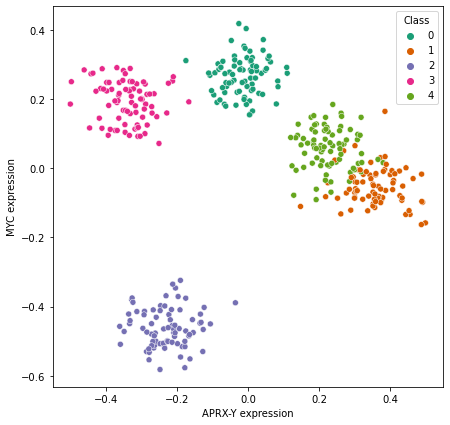

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

features, labels = make_blobs(n_samples = 500, n_features = 2, centers = 5, center_box = (-8, 8), 
                             random_state = 42)

#make train and test set
#make sure that the proportion of each class in the train and test set is equal
featsTrain, featsTest, labelsTrain, labelsTest = train_test_split(features, labels, test_size = 0.2, stratify = labels)
#normalise the data
featsTrain, muFeatsTrain, rangeFeatsTrain = createNormalisedFeatures(pd.DataFrame(featsTrain), "range")
featsTrain = np.array(featsTrain)
featsTest  = (np.array(featsTest) - np.array(muFeatsTrain))/np.array(rangeFeatsTrain)
#note how you normalise the training data, and then use the obtained means and ranges to transform the test data!

#Show the data
dataFrameFiveClasses = pd.concat([pd.DataFrame(featsTrain), pd.DataFrame(labelsTrain)], axis = 1)
dataFrameFiveClasses.columns   = ["APRX-Y expression", "MYC expression", "Class"]
display(dataFrameFiveClasses.head())

#Make a plot of the training data using Seaborn
fig, ax = plt.subplots(figsize = (7,7))
sns.scatterplot(x = "APRX-Y expression", y = "MYC expression", hue = "Class", data = dataFrameFiveClasses,
               palette= "Dark2", ax = ax)

#train logistic regression on this

## Doing multiclass logistic regression

Now it is up to you to perform multiclass logistic regression. For now let's not use regularisation. To do this, do the following:

* Make a list of thetas `finalThetasEachClass`.
* Loop over the labels (there should be 5 iterations)
* In each loop:
    * Make a new class array, that is 1 for the current class under consideration, and 0 for all others (use the training data).
    * Use this class array to train logistic regression. Rather than using gradient descent, use `fmin_bfgs(costFunction, startThetas, gradientFunction, (features, class))`.
    * Append the final thetas to the list.
* When that's done, use `np.c_[yourListName].T` on the list to get a matrix of thetas, where each column contains the thetas for a certain class, with the first row containing $\theta_0$, the second containing $\theta_1$ etc.
* Which class has the highest cost?
* Finally, uncomment the plotting code to see what decision boundary has been learned!

Hints:
* Make sure that your class labels are a 2D array, that is, look like this: $\begin{bmatrix} 0 \\ 1 \\ 1 \\ ... \\ 1 \\ 0 \end{bmatrix}$
* In the answers, I've drawn the decision boundaries as well, you don't need to do that here (but you can look at them).

0
Optimization terminated successfully.
         Current function value: 0.121956
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35
Optimised parameters: 
[-10.53264481  11.73535044  52.21485061]
1
Optimization terminated successfully.
         Current function value: 0.085847
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41
Optimised parameters: 
[-10.57952257  36.27558646 -24.51485469]
2
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Optimised parameters: 
[-20.05791012 -34.96048042 -71.31712366]
3
Optimization terminated successfully.
         Current function value: 0.011167
         Iterations: 47
         Function evaluations: 52
         Gradient evaluations: 52
Optimised parameters: 
[-16.84415291 -67.02115814  22.5218509 ]
4
Optimization terminated successfully.
        

/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_85734/4116722355.py:28: RuntimeWarning: invalid value encountered in log
  costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))


,0,1,2,3,4
0,-10.532645,-10.579523,-20.057910,-16.844153,-2.179942
1,11.735350,36.275586,-34.960480,-67.021158,5.702859
2,52.214851,-24.514855,-71.317124,22.521851,3.157010


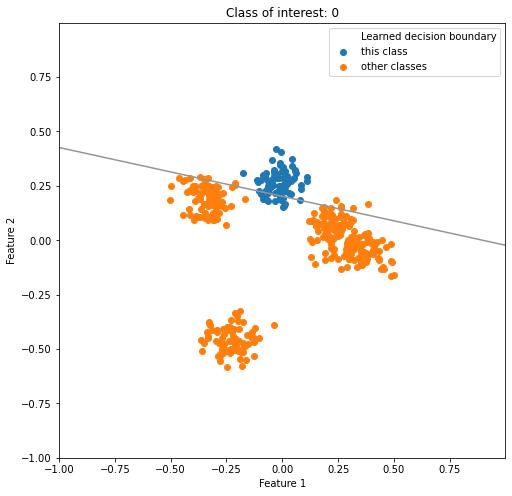

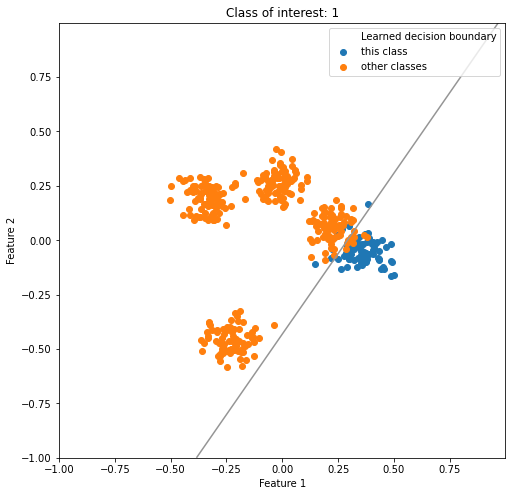

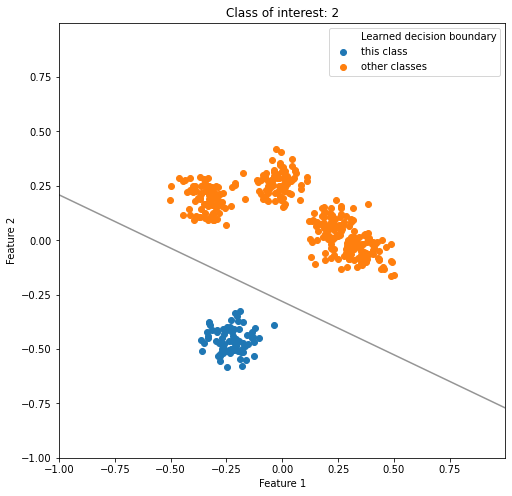

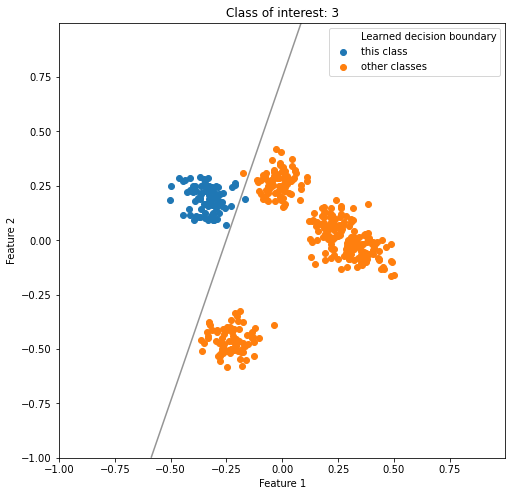

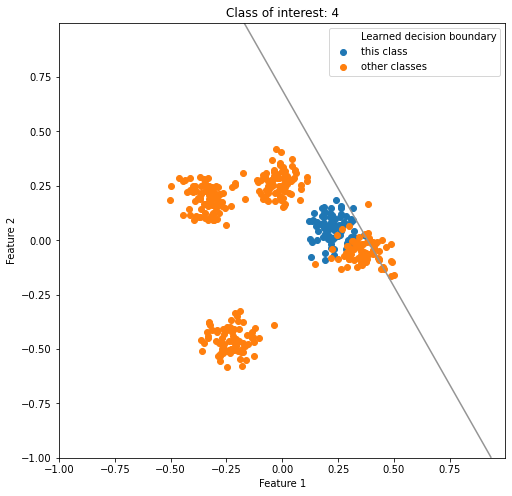

In [5]:
startThetas = np.array([0]*3) #2 features and intercept

# your answer




# uncomment the below for your final output

# thetasAllClasses = np.c_[SOMETHING].T


# plotting code. Once you have thetasAllClasses,
# uncomment this code to generate plots of the decision boundaries learned

# xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
# grid = np.c_[xx.ravel(), yy.ravel()]

# for classNumber in range(0, thetasAllClasses.shape[1]):
#     thisClassIndices    = np.where(labelsTrain == classNumber)
#     notThisClassIndices = np.where(labelsTrain != classNumber)
#     probs = linAlgLogRegHypothesis(grid, optimisedThetas).reshape(xx.shape)
#     fig, ax = plt.subplots(figsize = (8, 8))
#     b = ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=1)
#     ax.set_title("Class of interest: " + str(classNumber))
#     ax.set_xlabel("Feature 1")
#     ax.set_ylabel("Feature 2")
#     ax.scatter(featsTrain[thisClassIndices[0],0], featsTrain[thisClassIndices[0],1], label = "this class")
#     ax.scatter(featsTrain[notThisClassIndices[0],0], featsTrain[notThisClassIndices[0],1], label = "other classes")
#     b.collections[0].set_label("Learned decision boundary")
#     ax.legend()

# answer
finalThetasEachClass = []

for label in np.unique(np.sort(labelsTrain)):
    print(label)
    # labelsTrain == label gives us a list of True or False, true when the label is the current label under consideration
    # .astype(int) turns [True, False, True] into [1,0,1]. Then I turn it into a column vector again with
    # currentClassArray[:, np.newaxis]
    currentClassArray   = (labelsTrain == label).astype(int)
    currentClassArray   = currentClassArray[:, np.newaxis]
    optimisedThetas     = fmin_bfgs(costFuncLogReg, startThetas, computeGradients, (featsTrain, currentClassArray), gtol = 1e-06, retall = False)
    print("Optimised parameters: ")
    print(optimisedThetas)
    finalThetasEachClass.append(optimisedThetas)
    

thetasAllClasses = np.c_[finalThetasEachClass].T
print(thetasAllClasses.shape)
display(pd.DataFrame(thetasAllClasses))

# plotting code 
xx, yy = np.mgrid[-1:1:.001, -1:1:.001]
grid = np.c_[xx.ravel(), yy.ravel()]

for classNumber in range(0, thetasAllClasses.shape[1]):
    thisClassIndices    = np.where(labelsTrain == classNumber)
    notThisClassIndices = np.where(labelsTrain != classNumber)
    probs = linAlgLogRegHypothesis(grid, finalThetasEachClass[classNumber]).reshape(xx.shape)
    fig, ax = plt.subplots(figsize = (8, 8))
    b = ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    ax.set_title("Class of interest: " + str(classNumber))
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.scatter(featsTrain[thisClassIndices[0],0], featsTrain[thisClassIndices[0],1], label = "this class")
    ax.scatter(featsTrain[notThisClassIndices[0],0], featsTrain[notThisClassIndices[0],1], label = "other classes")
    b.collections[0].set_label("Learned decision boundary")
    ax.legend()
    # see: https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression for more info



#class 4 clearly has the highest cost, it gets a very strange decision boundary. Apparently nothing better can (easily) be found linearly.


## Making predictions with your learned decision boundaries

We didn't split our data into train and test subsets for nothing. We want to make some predictions! Luckily that's extremely easy. Look:

$$\begin{bmatrix}1 & 0.2 & 3 \\ 1 & -1.4 & 0.09 \end{bmatrix} \cdot \begin{bmatrix}\theta_0^1 & \theta_0^2 & \theta_0^3 \\ \theta_1^1 & \theta_1^2 & \theta_1^3 \\ \theta_2^1 & \theta_2^2 & \theta_2^3 \end{bmatrix}$$

Here, the superscript refers to the class, and the subscript to the parameter number. So $\theta_1^1$ is parameter 1 for the binary prediction whether something is class 1 or not class 1. You see that you'll get a 2 by 3 matrix as output (2 by 3 * 3 by 3 = 2 by 3), with on each row the output of the 3 separate classifiers in each column. You don't even have to do anything manually, as your `linAlgLogRegHypothesis` should do this for you automatically. To get your final prediction, you simply select the maximum of each row, and that's the class you predict!

Up to you to:
* Predict the probability of membership of each class for the `featsTest`. Use `thetasAllClasses` from above.
* Select the class with the highest probability, and set this as your predicted class label. You can get the highest entries per row with `np.amax(yourData, axis = 1)[:,np.newaxis]`. You should use `np.where`.
* Compare this with `labelsTest` and see what percentage you predict correctly.

Hints
* When using `np.where`, make sure you get only an array of labels, not the row positions as well (you need to subset) (use `[1]` after it).

In [6]:
# your answer here


# answer

predictions = linAlgLogRegHypothesis(featsTest, thetasAllClasses)
display(pd.DataFrame(predictions).head())

predLabels = np.where(predictions == np.amax(predictions, axis = 1)[:,np.newaxis])[1]

print("Percentage correctly predicted test: " + str(np.sum(predLabels == labelsTest)/len(predLabels)*100) + "%")

,0,1,2,3,4
0,9.694918e-03,1.691805e-12,3.101801e-10,9.999196e-01,0.030287
1,8.991944e-15,2.543895e-04,9.999984e-01,3.508945e-06,0.011578
2,1.059361e-04,7.560492e-01,1.092837e-12,4.833132e-17,0.349860
3,7.085201e-01,1.902464e-09,2.131580e-15,8.336480e-03,0.120897
4,2.902272e-16,5.210563e-03,1.000000e+00,6.978122e-08,0.011142


Percentage correctly predicted test: 95.0%


In [7]:
labels

array([1, 4, 4, 1, 2, 1, 2, 4, 0, 0, 1, 1, 1, 4, 3, 3, 1, 3, 2, 1, 4, 3,
       2, 3, 0, 3, 0, 3, 2, 1, 0, 0, 0, 4, 4, 0, 3, 1, 3, 0, 3, 1, 0, 3,
       0, 2, 0, 3, 2, 2, 2, 0, 4, 1, 4, 4, 4, 3, 3, 2, 2, 0, 4, 2, 0, 4,
       4, 2, 4, 4, 1, 1, 4, 1, 4, 1, 1, 0, 3, 2, 2, 0, 1, 3, 2, 3, 1, 1,
       0, 1, 4, 2, 1, 2, 0, 1, 0, 2, 1, 4, 4, 4, 0, 1, 0, 2, 2, 2, 2, 2,
       4, 0, 1, 4, 2, 4, 3, 3, 2, 4, 3, 4, 4, 4, 4, 2, 0, 1, 2, 4, 1, 3,
       4, 3, 1, 3, 2, 1, 4, 4, 2, 2, 3, 2, 2, 3, 4, 2, 3, 4, 3, 1, 0, 0,
       0, 3, 4, 4, 2, 0, 4, 0, 2, 3, 3, 2, 3, 1, 1, 3, 1, 1, 3, 4, 2, 4,
       0, 0, 2, 4, 0, 0, 2, 1, 3, 0, 2, 0, 0, 4, 4, 1, 4, 0, 3, 3, 3, 4,
       3, 1, 4, 0, 0, 3, 4, 0, 0, 3, 4, 4, 2, 4, 3, 1, 1, 4, 3, 3, 2, 0,
       0, 3, 0, 4, 0, 1, 1, 0, 3, 1, 1, 0, 0, 4, 2, 1, 3, 2, 0, 2, 3, 3,
       0, 2, 1, 4, 2, 3, 0, 1, 4, 2, 1, 0, 2, 0, 4, 4, 0, 4, 1, 1, 0, 4,
       0, 3, 2, 1, 0, 1, 3, 0, 0, 1, 4, 0, 0, 0, 1, 4, 3, 0, 2, 1, 0, 3,
       1, 2, 4, 1, 2, 3, 0, 0, 1, 3, 1, 3, 2, 3, 1,

## Multiclass classification on MNIST

It's nice to have a baseline of performance before we move on to a neural network. We can also run a multiclass logistic regression on the MNIST dataset. This means that in this case you get a matrix of theta values, one set for each class. The (downscaled) MNIST data consists of 8 \* 8 grayscale images, i.e. 64 values between 0-16 that indicate the intensity of a pixel (0=black, 16 = white). To make this matrix of values into something logistic regression can work with, we simply paste the rows of pixel intensities one after the other into a 1 by 64 row vector. After the 10 classifiers have been trained, you predict with all of them on the test data, and then simply pick the highest probability among them as the class to predict for that digit.

Below we load in the data and show some digits. Then, there's code to train the logistic regression to see what the baseline performance is like for simple logistic regression.

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,178,182,177,183,181,182,181,179,174,180


Amount of samples per digit train:


,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,142,145,142,146,145,146,145,143,139,144


Amount of samples per digit test:


,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,36,37,35,37,36,36,36,36,35,36


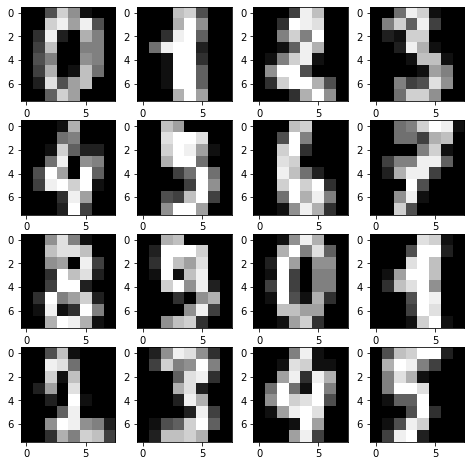

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
mnistData = load_digits()
print(mnistData.DESCR)
print("\n________________________________________\n")

print("Amount of samples per digit:")
display(pd.DataFrame(np.unique(mnistData.target, return_counts = True)))

#plot first 16 images
fig, axes = plt.subplots(4, 4, figsize = (8,8))
counter = 0
for imageRow in range(0,4):
    for imageCol in range (0,4):
        axes[imageRow, imageCol].imshow(mnistData.images[counter], cmap='gray', vmin = 0, vmax = 16, interpolation='none')
        counter += 1

#split the data into train and test, keeping class percentage equal, using a function from scikit-learn
X, y                                          = load_digits(return_X_y= True)
X_train, X_test, y_train, y_test              = train_test_split(X, y, train_size = 0.8, stratify = y)
normalised_X_train, means_train, ranges_train = createNormalisedFeatures(X_train, "range")
normalised_X_train                            = np.array(normalised_X_train)
normalised_X_test                             = (X_test - means_train)/ranges_train

print("Amount of samples per digit train:")
display(pd.DataFrame(np.unique(y_train, return_counts = True)))
print("Amount of samples per digit test:")
display(pd.DataFrame(np.unique(y_test, return_counts = True)))





## Performing multiclass (one-vs-all) logistic regression on MNIST

In an earlier version of this course, training logistic regression on MNIST was also an exercise. However, since it's a repetition of what we did on the sample data to get a baseline for neural network performance, it's not that important to do it yourself. Hence, just run the code and marvel at the results (;


/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_85734/4116722355.py:28: RuntimeWarning: invalid value encountered in log
  costsPerSample   = -y * np.log(predictions+smallValueToPreventInfinity) - (1-y) * np.log(1 - (predictions+smallValueToPreventInfinity))
/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_85734/4116722355.py:4: RuntimeWarning: overflow encountered in exp
  output = 1/(1+ np.exp(-data))


Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 43
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 207
         Function evaluations: 209
         Gradient evaluations: 209
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 65
         Function evaluations: 67
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 139
         Function evaluations: 141
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 70
         Function evaluations: 72
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 94
         Function evaluations:

,0,1,2,3,4,5,6,7,8,9
0,-51.660247,-2732.479193,-204.914837,-1278.076018,-23.690655,-419.071873,-351.395862,-93.159680,-11.571210,-3676.341288
1,15.777059,834.500194,62.581070,390.324907,7.235135,127.984711,107.316431,28.451002,3.533852,1122.756040
2,12.373966,720.153401,64.677694,533.958729,3.541754,175.985892,71.799549,-4.692052,3.310839,-880.936443
3,-10.875271,729.741905,81.977752,-522.377912,-30.266296,468.478608,-185.179867,44.724659,3.024774,232.129020
4,9.405586,1368.826456,-13.535055,53.161967,-105.486553,-127.780091,-104.223260,16.276859,-4.008769,2195.485582
...,...,...,...,...,...,...,...,...,...,...
60,6.549306,-743.647880,-56.124632,-33.353363,-78.098142,133.250170,-157.785405,-130.753272,2.185549,-1007.268044
61,-16.733523,1486.841068,-23.358636,25.897253,-37.216975,-139.264220,-88.833602,-60.435816,3.702257,17.415398
62,-23.908251,849.254877,226.646771,67.244435,-71.802294,-255.797612,151.815420,-163.293035,-4.158938,1801.374971
63,-9.732415,-19.071275,296.107077,-229.020462,-32.862318,-177.599064,-79.453607,-61.915614,-1.739377,-390.564026


Percentage correctly predicted test set: 93.33333333333333%


/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_85734/4116722355.py:4: RuntimeWarning: overflow encountered in exp
  output = 1/(1+ np.exp(-data))


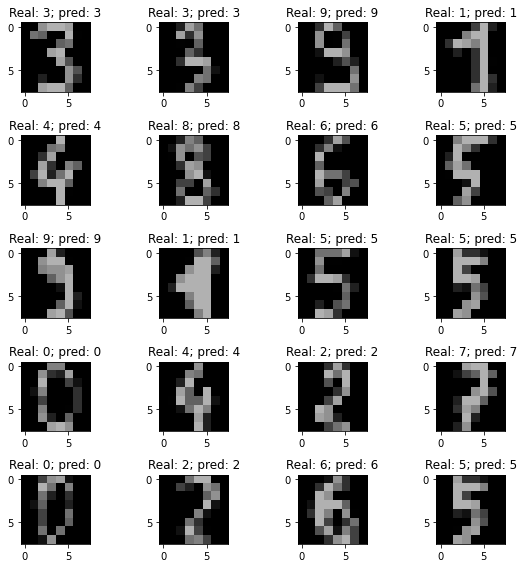

In [9]:
# if you get many warning messages from fmin_bfgs, try this alternative sigmoid function:

# def mySigmoid(data):
#     data = np.array(data)
#     return scipy.special.expit(data)

#Why this? Well, with many parameters and large values, numerical precision for the power function becomes
# an issue. Read here: https://github.com/scipy/scipy/blob/91a279ecb05e7814e2787bfa618d46ad3e0af2be/scipy/special/_logit.h
# how scipy fixes that. 

startThetas = [0]*65 #64 pixels and the intercept parameter

finalThetasEachDigit = []
for label in np.unique(np.sort(y_train)):
    currentClassArray = (y_train == label).astype(int)[:, np.newaxis]
    optimisedThetas   = fmin_bfgs(costFuncLogReg, startThetas, computeGradients, (normalised_X_train , currentClassArray))
    finalThetasEachDigit.append(optimisedThetas)

thetaMatrix = np.c_[finalThetasEachDigit].T
display(pd.DataFrame(thetaMatrix))

predictionsMNIST = linAlgLogRegHypothesis(normalised_X_test, thetaMatrix)
predLabelsMNIST  = np.argmax(predictionsMNIST, axis = 1)
print("Percentage correctly predicted test set: " + str(np.sum(predLabelsMNIST == y_test)/len(y_test)*100) + "%")

twentyRandomIndices = np.random.randint(0, len(normalised_X_test), 20)
fig, axes = plt.subplots(5, 4, figsize = (8,8))
counter = 0
for imageRow in range(0,5):
    for imageCol in range (0,4):
        axes[imageRow, imageCol].imshow(np.reshape(normalised_X_test[twentyRandomIndices[counter]], newshape = mnistData.images[0].shape),
                                        cmap='gray', vmin = 0, vmax = 1, interpolation='none')
        axes[imageRow, imageCol].set_title("Real: " +
                                           str(y_test[twentyRandomIndices[counter]]) +
                                           "; pred: " +
                                           str(predLabelsMNIST[twentyRandomIndices[counter]])
                                          )
        counter += 1
fig.tight_layout()




## Nested cross-validation

There's one thing I you haven't implemented yet, and that's nested cross-validation. What does it do? Well, remember those pesky hyperparameters like $\lambda$, the regularisation strength, and $\alpha$, the learning rate? I promised I'd let you know how to pick them. The most common way is through this nested cross-validation approach. Below, you will use scikit-learn to get the best value for alpha for a simple Ridge regression. Might be a relief after having to implent everything yourself so far (;

**Cross-validation recap** <br>
In cross-validation, you divide your dataset in k folds. You train on k-1 folds k times, and test on the kth fold k times. The average of this gives you a pretty good idea of your generalisation error. The purpose is not to use the k classifiers you trained further and pick the best among them or something, the purpose is to know how well you do on unseen data. <img src="cross-validation.png" alt="Drawing" style="width: 500px;"/>

**Hyperparameter optimisation and nested cross-validation** <br>
Let's say we want to pick our learning rate. The naive approach would be to try 5 learning rates (say 0.001, 0.01, 0.1, 1, 10). You could, in your cross-validation, train 5 classifiers on each fold, one with each learning rate, and look at their average performance on the test folds. Then you could pick the $\alpha$ that's best and be done with it. **That's wrong**. This is because you pick which learning rate is best based on how it performs on the test set: so you're choosing the hyperparameters that do best on your 'unseen' test set, and then reporting that average performance. You will hence be overconfident!

So what to do? Well: nested-cross validation. You make k-1 folds to train on. _Within_ those k-1 folds, you _again_ divide into folds, say l=5 folds. You train 5 classifiers on each of the l-1 subfolds, one for each value of $\alpha$. Then you test on the l-th fold. The $\alpha$ that perform best on average is the one you pick from among these sub-folds. Then, you move one level up again, and train using that alpha on the whole _upper_ fold of size k-1, and test using it on the k-th fold. Here is an image to further clarify: <br> <br>
<img src="nested-crossval.png" alt="Drawing" style="width: 760px;"/>

In the end, the whole goal is simple: you want to pick your hyperparameters based on _one_ unseen part of the data, and then measure your generalisation performance on some _other_ unseen part of the data that the hyperparameters were not fitted to, so you don't get a positive bias of your generalisation potential. 

**Choosing hyperparameters for a final model**  <br>
Now there's one little detail: this means you end up with k folds that were each, potentially, trained with different hyperparameters. Perhaps on fold 3, an $\alpha$ of 0.01 was best, but on fold 5 one of 0.001 was best. For your _final model_ you could then pick either the hyperparameter that is picked in most of your k folds, or you could take an average.

**Normalisation** <br>
To be entirely correct, you need to normalise the data separately within each inner fold. Otherwise signal from the test data (influence on the mean and variance) can leak into your training data. See 'data transformation with held out data' [here](https://scikit-learn.org/stable/modules/cross_validation.html). You'd really need an sklearn PipeLine for that, which is too advanced for now. So let's forget this for our current purposes.

**Your job** <br>
Whew, The Great Wall of Text, such a tourist attraction! We could implement this completely ourselves, using the k-fold cross-validation function I provided you with (and you optionally programmed yourself) in a nested fashion. But let's not be masochists for a change: understand the principle, but use sklearn to do it! Read [this tutorial](https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html) and adapt it to what you need to do below.
Up to you to:
* Use the data below to train regularised _linear regression_ . Now to make matters confusing, sklearn's implementation calls the regularisation parameter **_alpha_**. L2-regularised linear regression is called `Ridge`.
* You'll need to instantiate two k-fold splits `KFold()`. One for the inner, one for the outer. Make the outer 10, and the inner 5.
* Use `GridSearchCV` to train for 5 different values of lambda\alpha (given in a list below). Set `return_train_score = True`. In this way, `YourGridSearchCVObject.cv_results_` will show you the scores obtained for each of the 5 $\lambda$ parameters you use.
* Use `cross_validate` and **not** `cross_val_score`. With cross_validate, you will be able to access all the nested cross-validations performed. Make sure to set `return_estimator = True`.
* Use `for estimator in yourCrossValidateOutput: print(estimator.cv_results_)` to get a look-see inside. You should see that each estimator has 5 train scores and 5 test scores for each split (also 5 splits): 1 for each of the possible hyperparameters. The mean train score tells you how each of the 5 hyperparameters fared over the l folds. You'll see for this simple problem that 0.001 and 0.01 are equally good (and perfect).

Hints
* Use the tutorial I linked in the text above, then exchange cross_val_score for cross_val, and you're basically there.
* This sample ML problem is laughably easy and will give 100% performance, although for larger $\lambda$ values the score will start to suffer (underfitting).
* If this is too unclear, please tell me and I will go over it in class/we'll do it together.

Example values:


,Feature 1,Feature 2,Value
0,-0.765103,0.900392,1.664491
1,0.620915,-1.352208,-16.492697
2,-0.395846,0.878105,13.145472
3,0.938624,0.938529,58.617835
4,0.236104,-0.047836,7.722502


{'mean_fit_time': array([0.004529  , 0.00163813, 0.00148759, 0.00148745, 0.00089326]), 'std_fit_time': array([0.00384699, 0.00018565, 0.00045018, 0.00113811, 0.00038127]), 'mean_score_time': array([0.00019083, 0.00022426, 0.00031319, 0.00020981, 0.00016432]), 'std_score_time': array([3.20743798e-05, 8.56403519e-05, 2.65802762e-04, 8.12809464e-05,
       1.71915502e-05]), 'param_alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.001}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}], 'split0_test_score': array([1.        , 1.        , 0.99999992, 0.99999252, 0.99928795]), 'split1_test_score': array([1.        , 1.        , 0.99999994, 0.9999941 , 0.99943499]), 'split2_test_score': array([1.        , 1.        , 0.99999994, 0.99999421, 0.99944476]), 'split3_test_score': array([1.        , 1.        , 0.99999993, 0.99999344, 0.9993724 ]), 'split4_t

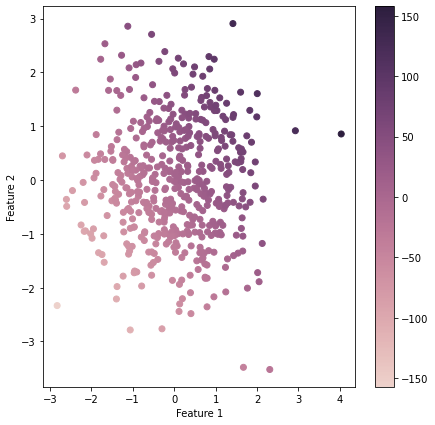

In [10]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV,  cross_validate

features, values = make_regression(n_samples = 500, n_features = 2, n_informative = 2, bias = 1.33,
                             random_state = 84)

#Show the data
dataFrameReg = pd.concat([pd.DataFrame(features), pd.DataFrame(values[:,np.newaxis])], axis = 1)
dataFrameReg.columns   = ["Feature 1", "Feature 2", "Value"]
print("Example values:")
display(dataFrameReg.head())

#Make a plot of the training data
cmap = sns.cubehelix_palette(as_cmap=True)
fig, ax = plt.subplots(figsize = (7,7))
points = ax.scatter(features[:,0], features[:,1], c = values, cmap = cmap)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
fig.colorbar(points)

param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]} #these are lambda values, that is, the hyperparameter for weight given to the square of the parameter values


# your answer here


#answer
model_to_tune = Ridge()

# Declare the inner and outer cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2, return_train_score = True)

# Outer cross-validation to compute the testing score
nestedCrossValOutcomes = cross_validate(model, features, values, cv=outer_cv, n_jobs=2, return_estimator = True)


# So what's happening here:
# The GridSearchCV describes a model whose hyperparameters are to be optimised by trying out different,
# specified combinations. You tell it to run on certain folds.

# The cross_validate function takes your model object, and trains it on features and values using outer_cv.
# So, this will make the k (here: 10) outer folds, train the model, and output the estimators trained etc.

# Because the model is not a trained model, but itself calls a cross-validation procedure (the GridSearchCV) with inner_cv,
# training it for a fold automatically means that the data from the k-1 folds passed is split yet again, now into
# 5 parts, the different regularisation parameters are used to train the model with each parameter once for each subfold
# and the model parameters that perform best are used to train the model over the outer k-1 folds and predict on the k-th
# fold.

for estimator in nestedCrossValOutcomes["estimator"]:
    print(estimator.cv_results_)

## Result of nested cross-validation

What you might realise is that we're now training a lot of classifiers. That is, you train k classifiers for k-fold cross-validation, but with internal cross-validation for hyperparameters, you add l internal folds * n_parameter settings classifiers for _each_ outer fold k. So above, we trained a cool 250 classifiers for internal cross_validation (5 internal folds * 5 parameter settings * 10 outer folds k) and 10 for the final outer cross validation (the k folds). You can imagine that with more parameter possibilities you want to try out, things start to get prohibitive.

For that, there's also random search, which, rather than trying out _every combination_ of a set of hyperparameters you want to try out, just tries out _n_ random values in intervals you pick. Turns out that also works pretty well.

As explained before, when training your final classifier on all your training data, and testing it on held-out test data that you kept separate from _the beginning of your project_, you can see which hyperparameters were picked to train with on the k outer folds in the end, and take an average for each hyperparameter, or the value that occurs most.

## Neural networks introduction (~60 minutes)

That's it for logistic regression. Now let's move on to neural networks, which, with the sigmoid activation function we use in them, are layered logistic regressors. In this way, they can extract basic features, then make some intermediate feature representations that help final classification, and then perform that final classification. Before you move on to the actual practical exercises at hand, it probably wouldn't hurt to reinforce what we've covered in the lectures. 3Blue1Brown has four _fantastic_ videos about neural networks. Watch the first 2 now:<br>
* [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=1)
* [Gradient descent, how neural networks learn](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=2)

**Optional: tinker on the online TensorFlow playground** <br>
You can spend a few minutes playing around on the online TensorFlow playground, and try to understand what's going on with the neural network there. Of course, you don't know how it's learning, but you can see how it works visually, which is always a great aid. Be sure to scroll down first and read what blue and orange mean: <br>

* [TensorFlow playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,3,2&seed=0.86244&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)




## Implementing feedforward neural networks yourself

**Note**: don't stress if you don't finish this: there is more time in the coming days, and truly implementing everything regarding neural networks yourself with linear algebra is very difficult. Hence, just continue at your own pace and I will assess where we get. In the end, you should understand what forward propagation and backpropagation are really doing and how they work under the hood. Writing all the code for it is a means to an end. Now, let's get cracking!

The image below was ~~shamelessly ripped from~~ taken from a practical on forward propagation by Andrew Ng on Coursera. It shows the neural network that we're going to use to perform our predictions with:
![NeuralNetworkImage](NeuralNetwork.PNG)

We'll give our 8\*8 data to the input units, shown in blue. This means that there are 64 input units (excluding the bias unit that always just outputs +1). Just to be clear: what are shown as, and called, input _units_ are just the _feature values_. There's no computation in the blue circles.

Then, there's a Hidden Layer consisting of 25 units (and the bias unit with the +1), and a final layer with 10 output units, that calculate the hypothesis function for each digit (i.e. chance that it is a 0, a 1, a 2, etc.).

You're given two _matrices_ of trained weights, $\Theta_1$ and $\Theta_2$. It'll be up to you to do the computations that finally result in the output of the neural network. Do this computation for the normalised_X_train from above. While we're not going to train the neural network here, remember that we now have our labels as (row) vectors. <br>
So, the digit 0 has as label: $$\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \end{bmatrix}$$
While the digit 5 has as label: $$\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{bmatrix}$$ <br>

Let's start with the simple part:

* Transform the numeric scalar labels (0-9) into vector labels (see above) using numpy or sklearn. Using OneHotEncoder from sklearn with `sparse = False` and using `.fit_transform(labelsToTransform)` is probably easiest.



In [12]:
thetaOneMatrix = np.loadtxt("thetaOneMatrixFFNN.csv", delimiter = ",")
thetaTwoMatrix = np.loadtxt("thetaTwoMatrixFFNN.csv", delimiter = ",")

#Your code here.



#answer

y_train_vector         = sklearn.preprocessing.OneHotEncoder(categories = "auto", sparse = False).fit_transform(y_train.reshape(-1,1))
y_test_vector          = sklearn.preprocessing.OneHotEncoder(categories = "auto").fit_transform(y_test.reshape(-1,1))

## Implementing forward propagation. 

### Worked example linear algebra forward propagation

To make matters simple, here is a small example network where everything is annotated. Let's walk through what the linear algebra implementation of forward propagation would look like. <br>

![image](../../Day3/Practical_3/ExampleNeuralNetwork5.PNG) <br>

The data looks like:

$$\begin{bmatrix} 1 & feat_1val_1 & feat_2val_1 \\ 1 & feat_1val_2 & feat_2val_2 \end{bmatrix}$$

The first matrix with the weights and biases is $\Theta^{(1)}$ and looks like this:

$$\begin{bmatrix} \mbox{biasneuron_1} & \mbox{weightinput_1neuron_1} & \mbox{weightinput_2neuron_1} \\  \mbox{biasneuron_2} & \mbox{weightinput_1neuron_2} & \mbox{weightinput_2neuron_2} \end{bmatrix}$$

And its transpose looks like: $$\begin{bmatrix} \mbox{b_n1} & \mbox{b_n2} \\ \mbox{w_1n_1} & \mbox{w_1n_2} \\ \mbox{w_2n_1} & \mbox{w_2n_2} \end{bmatrix}$$ 

Multiplied together you get: $ F \cdot {\Theta^{(1)}}^T$. 2 by 3 times 3 by 2 will make a 2 by 2 matrix of the weighted sums like so, $Z^{(l)} =$

$$ \begin{bmatrix} 1 \cdot \mbox{biasneuron_1} + \mbox{feat_1val_1} \cdot \mbox{weightinput_1neuron_1} + \mbox{feat_2val_1} \cdot \mbox{weightinput_2neuron_1} & 1 \cdot \mbox{biasneuron_2} + \mbox{feat_1val_2} \cdot \mbox{weightinput_1neuron_2} + \mbox{feat_2val_2} \cdot \mbox{weightinput_2neuron_2} \\ 1 \cdot \mbox{biasneuron_1} + \mbox{feat_1val_1} \cdot \mbox{weightinput_1neuron_1} + \mbox{feat_2val_1} \cdot \mbox{weightinput_2neuron_1} & 1 \cdot \mbox{biasneuron_2} + \mbox{feat_1val_2} \cdot \mbox{weightinput_1neuron_2} + \mbox{feat_2val_2} \cdot \mbox{weightinput_2neuron_2} \end{bmatrix}$$ 

In this matrix, each row contains the weighted sums, $z^{(l)}$ for this layer for a certain training example, with column 1 corresponding to neuron 1, and column 2 corresponding to neuron 2. We can now perform the sigmoid on this layer to get the activations. I'm shortening the terms to make things more legible.

$$ A^{(l)} = \begin{bmatrix} \sigma( 1 \cdot b_1 + f_{1}v_{1} \cdot w_1n_1 + f_2v_1 \cdot w_2n_1) &
\sigma( 1 \cdot b_2 + f_1v_2 \cdot w_1n_2 + f_2v_2 \cdot w_2n_2) \\ \sigma( 1 \cdot b_1 + f_1v_1 \cdot w_1n_1 + f_2v_1 \cdot w_2n_1) & \sigma( 1 \cdot b_2 + f_1v_2 \cdot w_1n_2 + f_2v_2 \cdot w_2n_2) \end{bmatrix} = \begin{bmatrix} a^{(l)}_1 & a^{(l)}_2 \\ a^{(l)}_1 & a^{(l)}_2 \end{bmatrix}$$ 

Now we take this, add again a row of 1 to be multiplied with the biases in ${\Theta^{(2)}}^T$ and do that multiplication. Note that I've added the layer indices as superscript to distinguish them from the previous layer's biases and weights:

$$Z^{(L)} = \begin{bmatrix} 1 & a^{(l)}_1 & a^{(l)}_2 \\ 1 & a^{(l)}_1 & a^{(l)}_2 \end{bmatrix} \cdot \begin{bmatrix} b^{L}_1 & b^{(L)}_2 & b^{(L)}_3 \\ w_1n_1^{(L)} & w_1n_2^{(L)} & w_1n_3^{(L)} \\ w_2n_1^{(L)} & w_2n_2^{(L)} & w_2n_3^{(L)}\end{bmatrix} = \begin{bmatrix} z^{(L)}_1 & z^{(L)}_2 & z^{(L)}_3 \\ z^{(L)}_1 & z^{(L)}_2 & z^{(L)}_3 \end{bmatrix}$$

Where again the first row are the weighted sums. Using the sigmoid activation function we get: 
$$\sigma(Z^{(L)}) = A^{(L)} = \begin{bmatrix} a^{(L)}_1 & a^{(L)}_2 & a^{(L)}_3 \\ a^{(L)}_1 & a^{(L)}_2 & a^{(L)}_3 \end{bmatrix}$$

It's these final activations that you can compare with labels, which look like this:
$$Y = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$$

## Doing this yourself

Okay, now that you've seen how to do it, I'll leave you to it. Make a forward pass through the network.

* Perform the computations with the two theta matrices such that you go from all the inputs (`normalised_X_train`) to the correct outputs. Don't forget to add bias units (i.e. a 1), and don't forget the activation function (sigmoid)! Make sure to do this with linear algebra: no loops! Finally: the HL has 25 units and the output layer 10 units.
* Once done, make the outcomes classifications (by setting the maximal outcome of the 10 output units as 1, and the rest as 0 in the predicted label)
* Then, check how many train samples are correctly predicted by these trained weight matrices (check whether the output labels are completely equal to the predicted labels).
* Once you're done, check the answers for some code to plot the misclassified samples and their predicted class.

Hints:
* If you get errors about needing to reshape, do exactly as they say.
* The Theta matrices contain the bias and the weights per unit in rows. So: the first row of $\Theta_1$ contains the bias in the first column, and then the 64 weights for the 64 pixels in the following columns.
* You might need to transpose (`.T`) things here to get the desired behaviour. 
* Check the slides for inspiration
* Remember to use `@` for matrix multiplication
* You can use `np.c_[]` in combination with `np.ones()` to append a column of all 1 to the inputs to a layer. Note: to make np.ones  return a column vector, make sure to set its `shape` argument to `(someDimension, 1)`
* To change the outcomes to class vectors, you can loop over the samples, set the maximum to 1 and the rest to 0, or do everything together with `np.where()` and `np.amax(theData, axis = 1)`.
* You might need `np.all(classLabelsPredicted == realClassLabels, axis = 1)`

Shape of weighted sum: 
(1437, 25)
This is correct: we now have for the 1437 samples a weighted sum, with the sum made by each unit (25 total) using its bias and weights in the columns
Shape of activations final layer:
(1437, 10)
That's as we expect, 1437 times 10 predictions!

Let's look at the first 2 samples:
[[5.17455959e-05 4.94768627e-04 4.08340505e-03 1.54341669e-01
  4.70841986e-06 1.65125175e-03 3.42799976e-06 4.03836705e-03
  4.78708027e-04 6.89491983e-03]
 [3.15638941e-05 8.34487704e-05 9.20700633e-05 6.41302978e-04
  2.08350403e-05 1.01581305e-01 1.03556279e-05 4.60946033e-04
  4.86317498e-04 3.56055483e-04]]
You see that the values are very small, but the predictions are nevertheless correct.
The maximal elements for sample 0 and 1 are:
[[0 1]
 [3 5]]
The actual labels for those digits are:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Or as numbers:
[3 5]
Nice to know that I didn't mess up the training of the network and saddle you with poor parameter

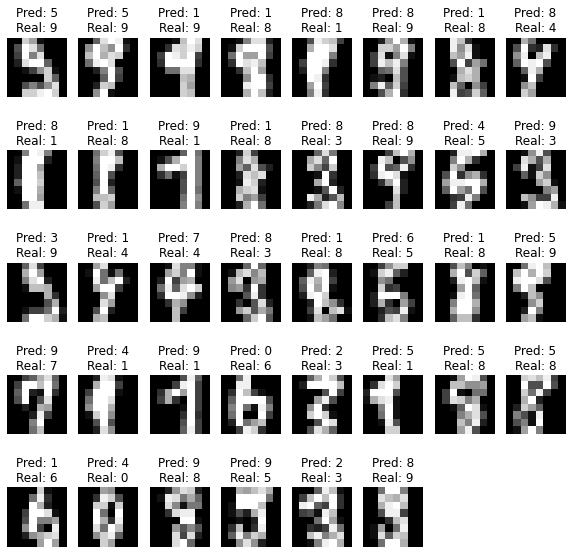

In [13]:
#Up to you
#use normalised_X_train; thetaOneMatrix and thetaTwoMatrix to get forward propagation working



#answer
xInputs                = np.c_[np.ones(shape = (len(normalised_X_train), 1)), normalised_X_train]

firstLayerWeightedSum  =  xInputs @ thetaOneMatrix.T
print("Shape of weighted sum: ")
print(firstLayerWeightedSum.shape)
print("This is correct: we now have for the 1437 samples a weighted sum, with the sum made by each unit (25 total) using its bias and weights in the columns")
firstLayerActivations  = mySigmoid(firstLayerWeightedSum)

secondLayerInputs      = np.c_[np.ones(shape = (len(firstLayerActivations), 1)), firstLayerActivations]
secondLayerWeightedSum = secondLayerInputs @ thetaTwoMatrix.T


#these are our 10 hypothesis functions, 1 for each class
secondLayerActivations = mySigmoid(secondLayerWeightedSum)
print("Shape of activations final layer:")
print(secondLayerActivations.shape)
print("That's as we expect, 1437 times 10 predictions!\n")

print("Let's look at the first 2 samples:")
print(secondLayerActivations[0:2, :])

print("You see that the values are very small, but the predictions are nevertheless correct.")
print("The maximal elements for sample 0 and 1 are:")
print(np.vstack(np.where(np.amax(secondLayerActivations[0:2, :], axis = 1)[:,np.newaxis] == secondLayerActivations[0:2, :])))
print("The actual labels for those digits are:")
print(y_train_vector[0:2,:])
print("Or as numbers:")
print(y_train[0:2])
print("Nice to know that I didn't mess up the training of the network and saddle you with poor parameters!")


#changing the outcome to classification vectors
outcomeCopy         = secondLayerActivations.copy()
outcomeClassVectors = np.where(np.amax(secondLayerActivations[:, :], axis = 1)[:,np.newaxis] == secondLayerActivations[:, :], 1, 0)

#checking whether the results are the collect labels
classificationCorrect = np.all(outcomeClassVectors == y_train_vector, axis = 1)
print("Correctly classified in the training data: " + str(np.sum(classificationCorrect)))
print("Incorrectly classified in the training data: " + str(np.sum(~classificationCorrect)))

print("Let's plot the samples where we were incorrect and our faulty predictions:")
wrongSampleIndices = np.ravel(np.where(~classificationCorrect))
figWrongPreds, axWrongPreds = plt.subplots(5, 8, figsize = (10,10))
sampleOne = normalised_X_train[0,:].reshape(8,8)
counter = 0
for row in range(0,5):
    for col in range(0,8):
        if counter >= len(wrongSampleIndices):
            break 
        axWrongPreds[row, col].imshow(normalised_X_train[wrongSampleIndices[counter],:].reshape(8,8),
                                      cmap = "gray", interpolation = "none")
        axWrongPreds[row, col].set_title("Pred: " + str(np.where(outcomeClassVectors[wrongSampleIndices[counter],:] == 1)[0][0]) + "\n" + "Real: " + str(y_train[wrongSampleIndices[counter]]))
        axWrongPreds[row, col].set_axis_off()
        counter += 1
for subPlotToDelete in [38, 39]:
    figWrongPreds.delaxes(axWrongPreds.flatten()[subPlotToDelete])
    
print("These are pretty difficult, especially with this small resolution.")

## What I want you to remember here:
* You know how to implement multiclass logistic regression
* You understand how to pick your final predictions: you take the maximum from separate classifiers trained per class
* You understand that neural networks using the sigmoid function are really just layered logistic regressors. By virtue of their layers, they can learn more complex features (as illustrated in the lectures with Boolean functions).
* You understand the use of the sigmoid activation function (i.e. to be able to fit nonlinear functions).
* You know how to implement forward propagation using linear algebra, and what forward propagation means and does.
* You understand nested-cross validation, and see why it is necessary.

## The end

Well done! You've done multiclass logistic regression and made your first steps towards understanding and implementing neural networks. You've earned yourself the definition of the word [niffer](https://www.merriam-webster.com/dictionary/niffer).

## Survey
Who could forget? [Click](https://docs.google.com/forms/d/e/1FAIpQLSfnHr02yXCsyrUTfTeMCEay3wOZLOquY8FuQMIsnkopL_1PFQ/viewform?usp=sf_link)


## Optional further scikit-learn preview

Hi there, welcome to this optional part that's optional. Did I mention it's optional? Wouldn't want to overwelm anyone with **optional** materials. Without further ado:

Yesterday you traded some of your precious little time on this planet to painstakingly implement gradient descent for linear regression yourself, and you did so this morning for logistic regression too. Turns out that's a sucker's game, because extremely cool and knowledgeable people have already put together a whole library that implements all sorts of ML algorithms, which allows you to train classifiers with very little code. 

Note that sklearn's predictors have methods that you'll work with to fit them to data and to predict on unseen data. As an example, a Random Forest implementation would look something like this: <br> <br>
`
myRandomForest = sklearn.ensemble.RandomForestClassifier(n_estimators = 80, max_depth = 2)
myRandomForest.fit(trainingFeatures, trainingLabels)
#predict class labels
myRandomForest.predict(testFeatures)
#predict class probabilities
myRandomForest.predict_proba(testFeatures)
#see the cost function/score (mean accuracy here)
myRandomForest.score(testFeatures, testLabels)
` <br> <br>
Your first order of business is to implement linear regression.   To do this:

* Import sklearn 
* Load the California housing dataset (look in [sklearn.datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)). Be sure to do `from sklearn import datasets` as well!
* Print exactly what the targets mean (what are the units of what you're predicting?), what the number of samples is, and use `DataFrame.describe()` to see the mean and distribution of the features (you'll need to convert to a DataFrame for that).
* Split the normalised data into train and test sets ( 80%, 20%, look [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).
* Normalise both features and the target to have zero mean and unit variance. Use [StandardScaler](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling). **Note: If you normalise train and test data together, information about the mean and variance of the test data 'leaks' into the transformed data: you've used aspects of the test data in transforming the train data. The correct way is to transform the train data, and then use the mean and variance calculated there to transform the test data. The StandardScaler link shows how to do this**
* Train linear regression without regularisation, and test on the test set. Print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).
* Train linear regression with L2 regularisation (penalising the sum of squares of the parameters). This is called Ridge regression. Set its $\lambda$ (which is confusingly called alpha) to 1.  Test on the test set and print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).
* Train linear regression with L1 regularisation (penalising the sum of the absolutes of the parameters). This is called LASSO regression. Set its $\lambda$ (which is confusingly called alpha) to 0.01. Test on the test set and print the $R^2$ (use `.score`). Also print the learned parameters/weights (use `.coef_`).

Hints:
* It seems like a lot of steps, but it's all basically one-liners in sklearn (okay some are three-liners).
* Search the documentation for the right predictor or functionality. You'll have to learn to navigate it anyway!
* If you don't know what $R^2$ is, see [this](https://www.youtube.com/watch?v=2AQKmw14mHM).

In [11]:
#answer
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

featuresHousing, targetsHousing = sklearn.datasets.fetch_california_housing(return_X_y = True)

#see here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset 
print("The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).")
print("Number of samples: " + str(len(featuresHousing)))
display(pd.DataFrame(featuresHousing).describe())

#split
featsHouseTrain, featsHouseTest, targetsHouseTrain, targetsHouseTest = train_test_split(featuresHousing, targetsHousing,
                                                                                        random_state = 42,
                                                                                        test_size = 0.2)
#normalise
#for this transformer, fitting means 'calculate the means and variances with which to perform the scaling'
scalerFeats = preprocessing.StandardScaler().fit(featsHouseTrain)
print("Feature means: " + str(scalerFeats.mean_))
print("Feature std: " + str(scalerFeats.scale_))
print("The slight mismatch in std between pandas and the scaler is probably\nin the way the standard deviation is calculated (either divided by n or by n-1)")
#transforming is where we actually take the original features, remove the means, and divide by the standard deviation.
scaledFeatsTrain, scaledFeatsTest = scalerFeats.transform(featsHouseTrain), scalerFeats.transform(featsHouseTest)

#ow for the targets
#reshape because the error message told me to: StandardScalar wants columns with values over which to perform.
scalerTargets = preprocessing.StandardScaler().fit(targetsHouseTrain.reshape(-1,1))
scaledTargetsTrain, scaledTargetsTest = scalerTargets.transform(targetsHouseTrain.reshape(-1,1)), scalerTargets.transform(targetsHouseTest.reshape(-1,1))
#make targets 1D again
scaledTargetsTrain, scaledTargetsTest = np.ravel(scaledTargetsTrain), np.ravel(scaledTargetsTest)

print("-----------------")
print("Scaled targets:")
print(scaledTargetsTrain)

#fit normal linear regression
linearRegressor             = LinearRegression().fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionTrain = linearRegressor.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionTest  = linearRegressor.score(scaledFeatsTest, scaledTargetsTest)
print("Normal linear regression:")
print("Train R^2: " + str(scoresLinearRegressionTrain))
print("Test R^2 : "  + str(scoresLinearRegressionTest))
print("Learned Parameters: " + str(linearRegressor.coef_) + "\n")

#L2 Regularised:
linearRegressorRidge             = Ridge(alpha = 1).fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionRidgeTrain = linearRegressorRidge.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionRidgeTest  = linearRegressorRidge.score(scaledFeatsTest, scaledTargetsTest)
print("Ridge regression:")
print("Train R^2: " + str(scoresLinearRegressionRidgeTrain))
print("Test R^2 : " + str(scoresLinearRegressionRidgeTest))
print("Learned Parameters: " + str(linearRegressorRidge.coef_) + "\n")

#L1 Regularised
linearRegressorLasso             = Lasso(alpha = 0.01).fit(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionLassoTrain = linearRegressorLasso.score(scaledFeatsTrain, scaledTargetsTrain)
scoresLinearRegressionLassoTest  = linearRegressorLasso.score(scaledFeatsTest, scaledTargetsTest)
print("Lasso regression:")
print("Train R^2: " + str(scoresLinearRegressionLassoTrain))
print("Test R^2 : " + str(scoresLinearRegressionLassoTest))
print("Learned Parameters: " + str(linearRegressorLasso.coef_) + "\n")

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).
Number of samples: 20640


,0,1,2,3,4,5,6,7
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Feature means: [ 3.88075426e+00  2.86082849e+01  5.43523502e+00  1.09668475e+00
  1.42645300e+03  3.09696119e+00  3.56431492e+01 -1.19582290e+02]
Feature std: [1.90423626e+00 1.26021177e+01 2.38730258e+00 4.33201426e-01
 1.13702195e+03 1.15783935e+01 2.13660060e+00 2.00559281e+00]
The slight mismatch in std between pandas and the scaler is probably
in the way the standard deviation is calculated (either divided by n or by n-1)
-----------------
Scaled targets:
[-0.90118909  1.5127714  -0.29921255 ...  0.12891731  0.65997132
  1.01890847]
Normal linear regression:
Train R^2: 0.6125511913966952
Test R^2 : 0.5757877060324508
Learned Parameters: [ 0.73896341  0.10599132 -0.25463792  0.29342852 -0.00199597 -0.03531345
 -0.77576169 -0.75233381]

Ridge regression:
Train R^2: 0.6125511218634558
Test R^2 : 0.5758157428913682
Learned Parameters: [ 0.73891476  0.10605855 -0.25446513  0.29321095 -0.0019739  -0.03531684
 -0.77510324 -0.75166694]

Lasso regression:
Train R^2: 0.6071014476004367
Test

## Quick sklearn wrap-up
As you can appreciate, training classifiers in this way is pretty easy. Thank open-source developers who implement these routines in an optimised and uniformly usable way. We'll be using sklearn here and there throughout the week, and you'll switch to it for your project next week.